# Scraping bina.az (real estate website in Azerbaijan) data to predict house price in Baku

In [1]:
# Importing necessary libraries
import requests
import bs4 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Scraping

In [3]:
# Base URL
base_url = 'https://bina.az/baki/alqi-satqi/menziller'

# Defining total pages, it has max 1529 pages
total_pages = 1530

# Create a list of dictionaries to store the extracted information
data_list = []

# Iterate through pages of the website
for page in range(1, total_pages):
    # Get the URL of the page
    url = base_url + "?page=" + str(page)
    response = requests.get(url)

    # Parse the HTML content
    soup = bs4.BeautifulSoup(response.content, 'html.parser')

    # Find all the flat listings on the page
    flat_listings = soup.find_all('div', class_='items-i')

    # Iterate through each flat listing
    for flat in flat_listings:
        # Extract the desired information for each flat
        price = flat.find('span', class_='price-val').text
        location = flat.find(class_='location').text
        date = flat.find(class_='city_when').text.rsplit(", ", 1)[-1]
        
        bill_element = flat.find('div', class_='bill_of_sale')
        bill = bill_element.span.text if bill_element is not None else ''
        
        repair_element = flat.find('div', class_='repair')
        repair = repair_element.span.text if repair_element is not None else ''
        
        mortgage_element = flat.find('div', class_='mortgage')
        mortgage = mortgage_element.span.text if mortgage_element is not None else ''
        
      
        name_element = flat.find('ul', class_='name')
        name_items = name_element.find_all('li') if name_element is not None else []
        room = name_items[0].text.split()[0] if len(name_items) > 0 else ''
        area = name_items[1].text.split()[0] if len(name_items) > 1 else ''
        floor = name_items[2].text.split()[0] if len(name_items) > 2 else ''

        # Create a dictionary for the extracted information
        data_dict = {
            'Price': price,
            'Location': location,
            'Date': date,
            'Bill': bill,
            'Repair': repair,
            'Mortgage': mortgage,
            'Room': room,
            'Area': area,
            'Floor': floor
        }

        # Append the dictionary to the list
        data_list.append(data_dict)

## Getting dataframe and first observation

In [59]:
# Create a dataframe from the list of dictionaries
df = pd.DataFrame(data_list)

In [60]:
df.head()

,Price,Location,Date,Bill,Repair,Mortgage,Room,Area,Floor
0,400 000,Nəsimi m.,12 i̇yul 2023,Çıxarış var,,,5,250,7/18
1,84 840,Memar Əcəmi m.,03 avqust 2023,,,,2,60.6,17/17
2,660 000,Nəsimi r.,24 i̇yul 2023,Çıxarış var,,,4,220,5/18
3,253 400,Şah İsmayıl Xətai m.,bugün 09:17,,,İpoteka var,2,90.5,18/20
4,742 210,Yasamal r.,dünən 17:24,,,,4,212.1,


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48928 entries, 0 to 48927
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     48928 non-null  object
 1   Location  48928 non-null  object
 2   Date      48928 non-null  object
 3   Bill      48928 non-null  object
 4   Repair    48928 non-null  object
 5   Mortgage  48928 non-null  object
 6   Room      48928 non-null  object
 7   Area      48928 non-null  object
 8   Floor     48928 non-null  object
dtypes: object(9)
memory usage: 3.4+ MB


In [62]:
df.describe(include='all')

,Price,Location,Date,Bill,Repair,Mortgage,Room,Area,Floor
count,48928,48928,48928,48928,48928,48928,48928,48928,48928
unique,1934,109,1147,2,2,2,14,1154,371
top,135 000,Nəsimi r.,08 avqust 2023,Çıxarış var,Təmirli,,3,60,
freq,740,3247,3450,32634,32717,34910,19930,1562,6300


In [63]:
df.isna().sum()

Price       0
Location    0
Date        0
Bill        0
Repair      0
Mortgage    0
Room        0
Area        0
Floor       0
dtype: int64

## Data wrangling and exploratory data analysis

### Clean and preprocess the data 

In [64]:
# Convert numeric columns to appropriate data types
df['Price'] = df['Price'].str.replace(' ', '').astype(int)
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
df['Room'] = pd.to_numeric(df['Room'], errors='coerce')

In [65]:
# Convert 'Bill', 'Repair' and 'Mortgage' columns to binary indicator
df['Bill'] = df['Bill'].apply(lambda x: 1 if x else 0)
df['Repair'] = df['Repair'].apply(lambda x: 1 if x else 0)
df['Mortgage'] = df['Mortgage'].apply(lambda x: 1 if x else 0)

Could not handle the 'Date' column thus I would delete it, also it is date for renewing and can be confusing 

In [66]:
"""
# Get today's date
today = datetime.date.today()

# Calculate yesterday's date
yesterday = today - datetime.timedelta(days=1)

# Extract the date portion and replace with today's or yesterday's date
df['Date'] = df['Date'].apply(lambda x: today if 'bugün' in x else yesterday if 'dünən' in x else x)

# Define a dictionary to map Azerbaijani month names to English
month_mapping = {
    'yanvar': 'January',
    'fevral': 'February',
    'mart': 'March',
    'aprel': 'April',
    'may': 'May',
    'iyun': 'June',
    'iyul': 'July',
    'avqust': 'August',
    'sentyabr': 'September',
    'oktyabr': 'October',
    'noyabr': 'November',
    'dekabr': 'December'
}

# Define the format of the original date string
original_date_format = "%d %B %Y"

# Function to translate Azerbaijani month names to English
def translate_month(month):
    month = month.replace("i̇", "i")  # Remove the 'i̇' character
    return month_mapping.get(month.lower(), month)

# Convert the 'Date' column to datetime format
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x.split()[1].replace("i̇", ""), '%B').strftime('%m') + ' ' + translate_month(x.split()[1]) + ' ' + x.split()[2])
df['Date'] = pd.to_datetime(df['Date'], format='%m %B %Y')
"""
del df['Date']

### Data distribution

#### Numercial variables

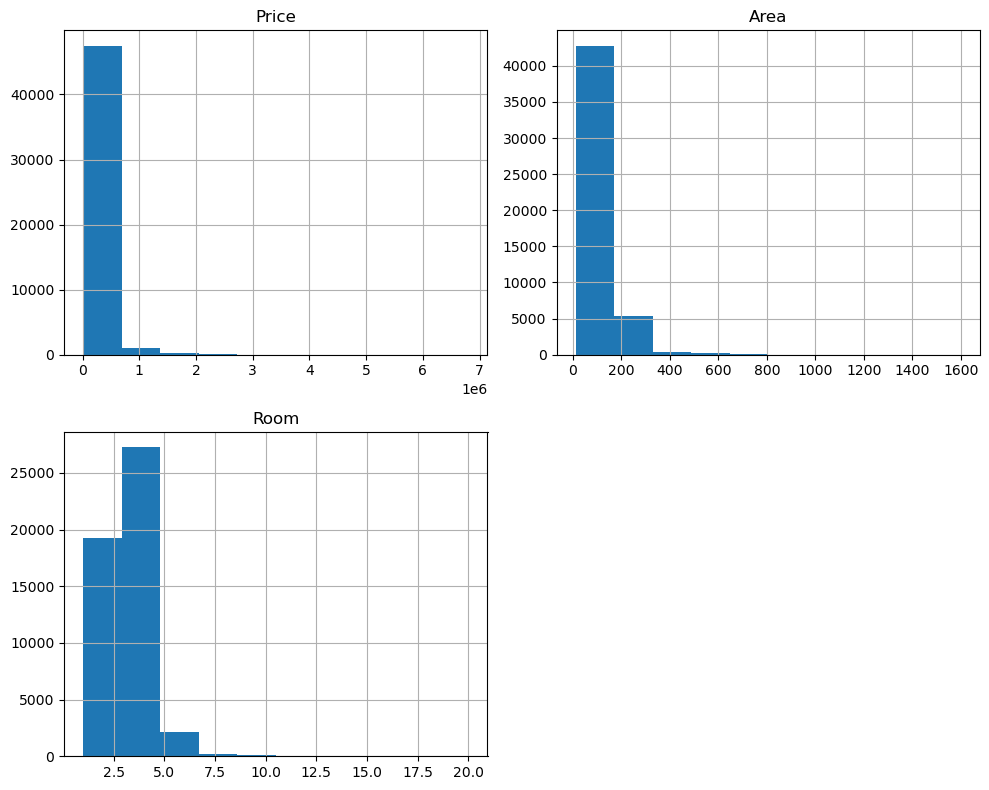

In [67]:
# Distribution of numerical features
numerical_features = ['Price', 'Area', 'Room']
df[numerical_features].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

#### Categorical features

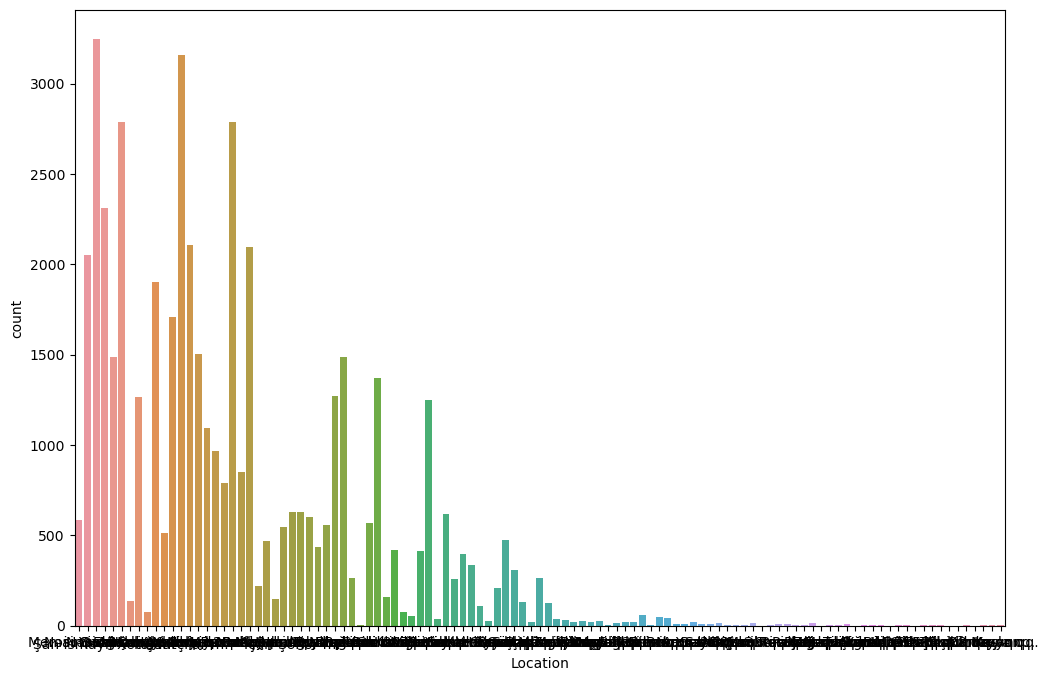

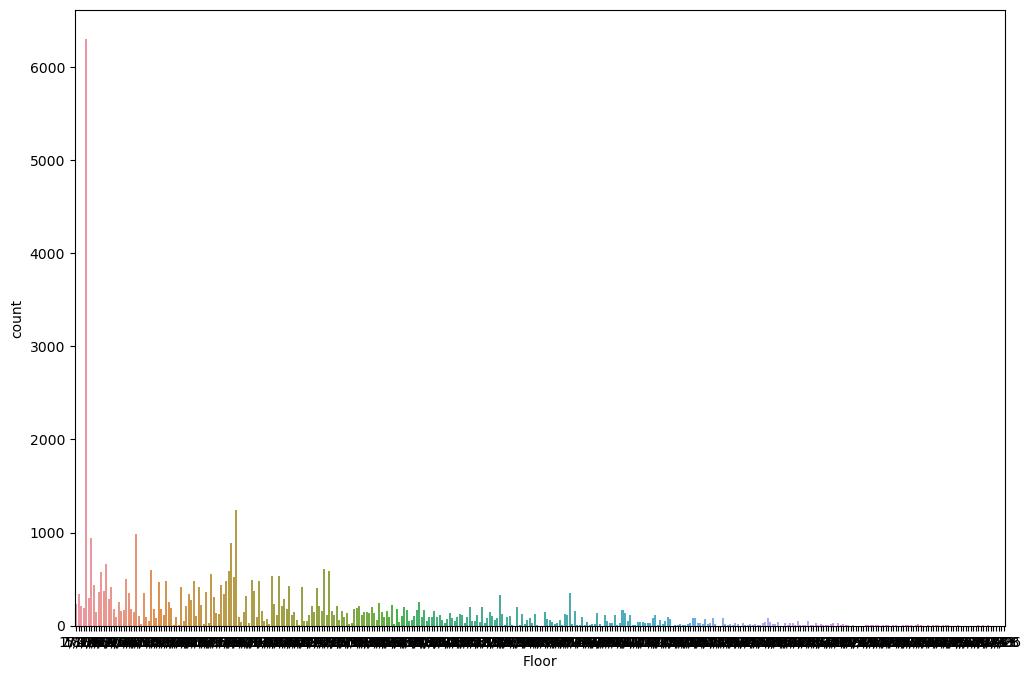

In [68]:
categorical_features = ['Location','Floor']
for feature in categorical_features:
    plt.figure(figsize=(12, 8))
    sns.countplot(data=df, x=feature)
    plt.show()


For Location and Floor columns there are too much unique values, we could deal later

### Detecting and handling outliers

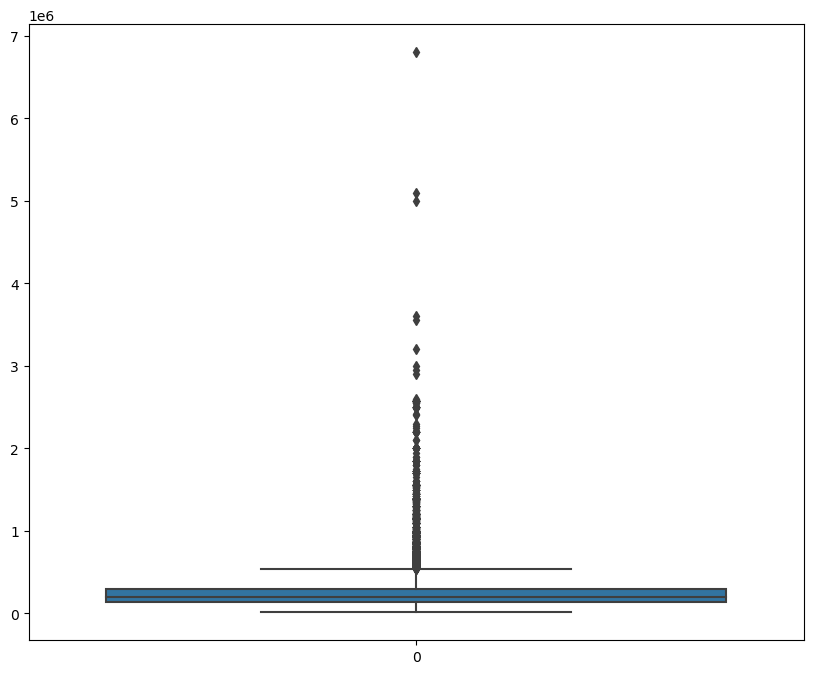

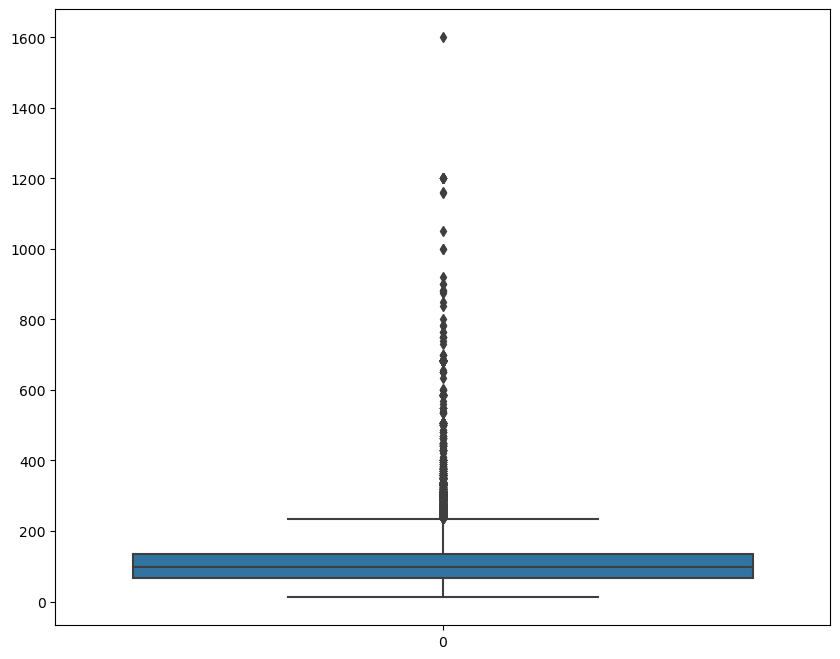

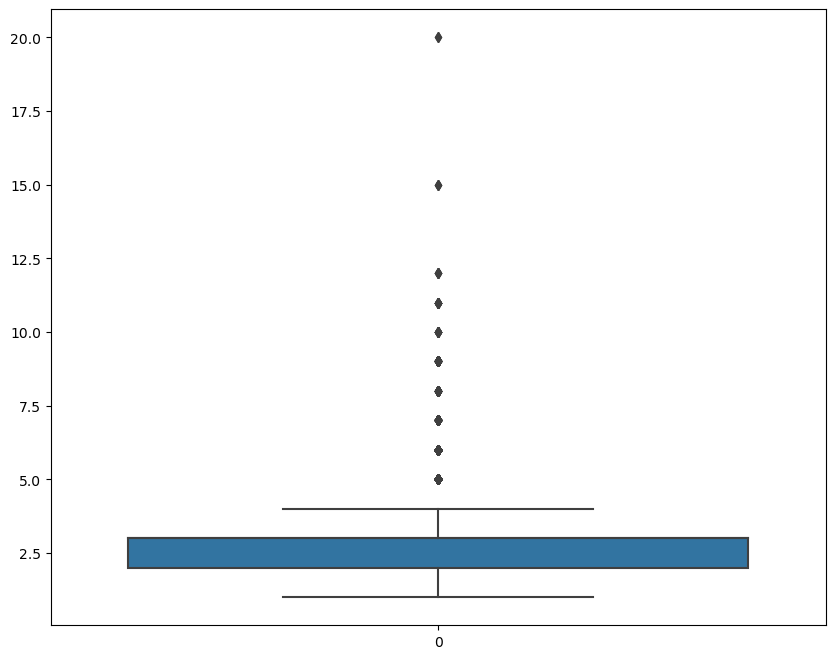

In [69]:
# Boxplot for numerical features to identify outliers
for feature in numerical_features:
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df[feature])
    plt.show()

In [70]:
# Handle outliers using the IQR method
for feature in ['Area', 'Room']:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)]
    
df=df[df['Price']<500000]

### Correlations 

C:\Users\lamanara\AppData\Local\Temp\ipykernel_804\3742616486.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


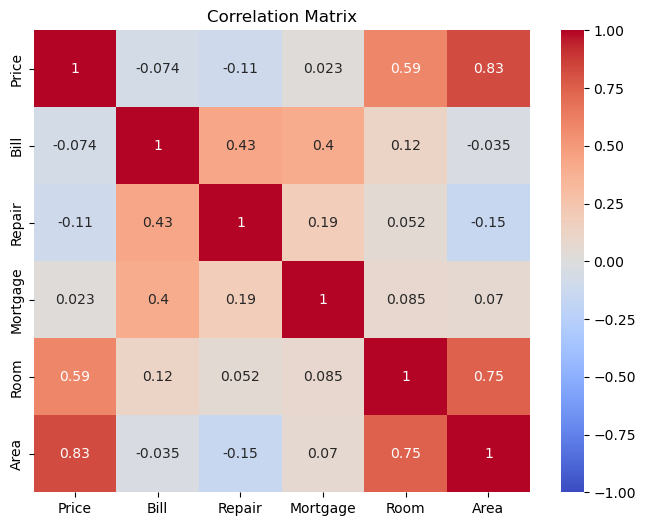

In [71]:
# Create a correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

There is high correlation between room and area as expected. 
Also there is high corr between bill and repair, and between bill and mortgage

## Feature engineering

In [72]:
# Create new columns based on the 'Floor' column
floor_split = df['Floor'].str.split('/', expand=True)
first_value = floor_split[0].replace('', np.nan).astype(float).fillna(0).astype(int)
second_value = floor_split[1].replace('', np.nan).astype(float).fillna(0).astype(int)

df['first_floor'] = np.where(first_value == 1, 1, 0)
df['last_floor'] = np.where(first_value == second_value, 1, 0)
del df['Floor'] # no need anymore

### Feature selection

Delete location column cause there too much uniqueness 

In [73]:
del df['Location']

#### Correlation between target and other numerical columns

In [74]:
price_corr = df.corr()['Price'].drop('Price')
price_corr

Bill          -0.074307
Repair        -0.106508
Mortgage       0.023337
Room           0.586057
Area           0.826276
first_floor   -0.136008
last_floor    -0.037650
Name: Price, dtype: float64

Due to high intercorrelation between area and room and since area has higher correlation with target value, delete room column and keep area

In [75]:
del df['Room']

In [76]:
# Prepare the features and target variable
X = df.drop('Price', axis=1)  # Features (all columns except 'Price')
y = df['Price']  # Target variable

#### Test for multicollinearity


In [77]:
# VIF 
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

       Feature       VIF
0         Bill  4.255012
1       Repair  3.508289
2     Mortgage  1.726377
3         Area  3.040498
4  first_floor  1.050639
5   last_floor  1.218938


Drop the 'Bill' column due to high inflation

In [78]:
del df['Bill']

## Modelling: Random Forest Regression

### Train data

Split the data into training and testing sets

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Create and train the Random Forest Regression model

In [80]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Predict on the test set

In [81]:
y_pred = model.predict(X_test)

## Model evaluation 

### Evaluation metrics

In [82]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

RMSE: 45993.23819950624
MAE: 30589.023756323877
R-squared: 0.7708168764482032


### Comparison

In [83]:
price_comparison = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print(price_comparison)

       Actual Price  Predicted Price
46734         90000     86511.515645
41583        207000    154407.858697
45463        370000    301779.014522
36127        233000    244827.022733
23869        250000    186849.419026
...             ...              ...
39080        290000    310066.355745
38718         62000    116984.621848
47399        174900    174900.000000
34674        452500    260297.733672
2472         189000    168762.943242

[17604 rows x 2 columns]
